# 1. Field Shaping Algorithm in JAX

The rotating magnetic setup consists of two identical rotating magnetic arrays with a certain distance between them. This  setup experiences magnetic field gradients parallel to the array when simple block magnets are used. These gradients generate unwanted forces, preventing the system from operating purely based on magnetic torque. While weaker magnets and minimizing the distance between opposing magnets can reduce these gradients, small residual gradients will persist.    

Several approaches can be used to further lower the magnetic gradient, including modifying magnetization strength, adjusting geometric properties, or changing the distance between opposing magnets. Among these, adjusting the distance between the opposing magnets is the most practical option, as it can be easily achieved by using multiple small magnets and 3D-printed slots to control their spacing. In contrast, altering geometric or magnetic properties is more challenging due to the limited availability of magnet shapes and the complexity of manufacturing custom magnet geometries.    

This notebook calculates the optimal magnetic setup for a specified magnetic field strength with the smallest possible gradient parallel to the magnets. This ensures that the rotating magnetic setup operates purely with torque without creating any unwanted gradients parallel to the magnets.

We rely on JAX, an advanced library from Google that combines just-in-time (JIT) compilation, automatic differentiation (autograd), and Accelerated Linear Algebra (XLA) for high-performance computing in Python. By JIT compiling numerical routines, JAX converts Python functions into optimized machine code, substantially speeding up repeated integrals over large magnet grids. Its autograd feature allows gradient-based optimization, making it easy to fine-tune magnet spacing for minimal residual gradients. Meanwhile, XLA provides hardware-specific optimizations to run computations efficiently on CPUs, GPUs, or TPUs. Together, these capabilities ensure our rotating magnetic setup can be rapidly evaluated and adjusted to achieve stable torque without unwanted forces.

## Initialize Notebook

In [1]:
import numpy as np
import time
import jax
import jax.numpy as jnp
import numpy.polynomial.legendre as lg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import itertools

TOL = 1e-5  # Tolerance for numerical integration
FIXED_ORDER = 4  # Fixed legendre polynomial order for GPU/TPU optimized calculations

## Plot Magnet Configuration

In [2]:
#------------------------------------------------------------------
# 1. plot_magnet_grid: Shows how all magnets are oriented and observation points in two views (XY and ZX). 
# Checks if the magnet orientation is physically possible and if the observation points are correctly specified. 
# Observation points can only vary along the x, y, or z axis when the other two axes are set to a scalar.
#------------------------------------------------------------------
def plot_magnet_grid(a_total, a_one, n_x, b_total, b_one, n_y, h, zl, x_val, y_val, z_val):
    # Magnet orientations error checks.
    tol = 1e-9 # Tolerance for rounding errors
    if len(zl) != n_x:
        raise ValueError("The length of the zl array must equal the number of columns (n_x).")
    if n_x * a_one > a_total + tol:
        raise ValueError("n_x * a_one must be ≤ a_total to avoid overlapping magnets.")
    if n_y * b_one > b_total + tol:
        raise ValueError("n_y * b_one must be ≤ b_total to avoid overlapping magnets.")
    
    # Compute centers for the XY-plane.
    x_centers = np.linspace(-a_total/2 + a_one/2, a_total/2 - a_one/2, n_x)
    y_centers = np.linspace(-b_total/2 + b_one/2, b_total/2 - b_one/2, n_y)
    
    # Process Observation Points.
    # Convert inputs to at least 1D arrays.
    x_val = np.atleast_1d(x_val)
    y_val = np.atleast_1d(y_val)
    z_val = np.atleast_1d(z_val)
    
    # Count how many observation inputs are arrays (size > 1).
    arr_count = sum(1 for arr in [x_val, y_val, z_val] if arr.size > 1)
    if arr_count > 1:
        raise ValueError("Observation points must be specified as either scalars or at most one array.")
    
    # Determine target size (if one array is provided, target_size > 1; otherwise target_size == 1)
    target_size = max(x_val.size, y_val.size, z_val.size)
    if target_size > 1:
        if x_val.size == 1:
            x_val = np.full(target_size, x_val[0])
        if y_val.size == 1:
            y_val = np.full(target_size, y_val[0])
        if z_val.size == 1:
            z_val = np.full(target_size, z_val[0])
    
    # Create Figure with Two Subplots.
    fig, (ax_xy, ax_zx) = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')
    ax_xy.set_facecolor('white')
    ax_zx.set_facecolor('white')
    
    # --- Create XY plot ---
    # Plot the Magnet Grid in the XY-Plane.
    for row in range(n_y):
        for col in range(n_x):
            rect_x = x_centers[col] - a_one/2.0
            rect_y = y_centers[row] - b_one/2.0
            magnet_rect = Rectangle((rect_x, rect_y), a_one, b_one,
                                      edgecolor='black', facecolor='lightgrey', lw=1)
            ax_xy.add_patch(magnet_rect)
    
    # Plot observation points on the XY-plane.
    ax_xy.plot(x_val, y_val, 'ro', markersize=2, label='Obs Points')
    ax_xy.set_title('Magnet Grid in XY-Plane')
    ax_xy.set_xlabel('x (m)')
    ax_xy.set_ylabel('y (m)')
    ax_xy.set_xlim(-a_total/1.8, a_total/1.8)
    ax_xy.set_ylim(-b_total, b_total)
    ax_xy.set_aspect('equal', adjustable='box')
    ax_xy.grid(True)
    ax_xy.legend()
    
    # --- Create XZ plot ---
    # Plot the Magnet Grid in the ZX-Plane (with Mirrored Arrays)
    for col in range(n_x):
        rect_x = x_centers[col] - a_one/2.0
        bottom_edge = zl[col]
        # Top block: spans from zl to zl + h.
        top_rect = Rectangle((rect_x, bottom_edge), a_one, h,
                              edgecolor='black', facecolor='lightgrey', lw=1)
        ax_zx.add_patch(top_rect)
        # Mirrored block: spans from -(zl + h) to -zl.
        bot_rect = Rectangle((rect_x, -(bottom_edge + h)), a_one, h,
                              edgecolor='black', facecolor='lightgrey', lw=1)
        ax_zx.add_patch(bot_rect)
    
    # Plot observation points on the ZX-plane.
    ax_zx.plot(x_val, z_val, 'ro', markersize=2, label='Obs Points')
    ax_zx.set_title('Magnet Grid in ZX-Plane')
    ax_zx.set_xlabel('x (m)')
    ax_zx.set_ylabel('z (m)')
    ax_zx.set_xlim(-a_total/1.8, a_total/1.8)
    z_upper = max(zl) + h
    z_lower = -(max(zl) + h)
    ax_zx.set_ylim(z_lower*1.2, z_upper*1.2)
    ax_zx.set_aspect('equal', adjustable='box')
    ax_zx.grid(True)
    ax_zx.legend()
    
    plt.tight_layout()
    plt.show()

## Magnet Dimensions

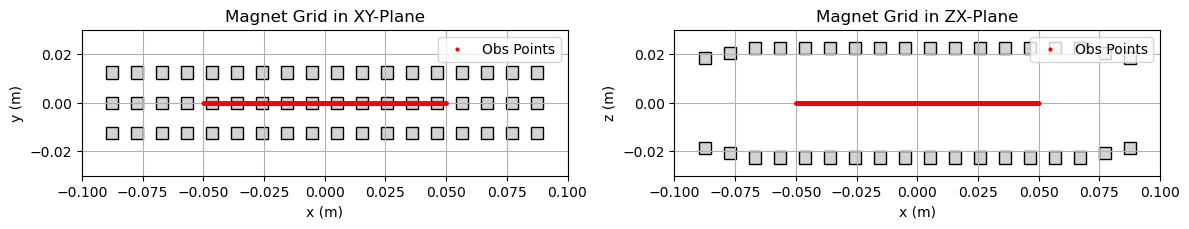

In [46]:
#------------------------------------------------------------------
# Dimensions and coordinates of the magnet grid, magnets and observation points.
#------------------------------------------------------------------
A_TOTAL = 180e-3    # Grid width (x-dimension)   
A_ONE   = 5e-3   # Magnet width (x-dimension)   
N_X     = 18     # Number of magnets in x-direction   
B_TOTAL = 30e-3    # Grid depth (y-dimension)   
B_ONE   = 5e-3     # Magnet depth (y-dimension)   
N_Y     = 3       # Number of magnets in y-direction   
H       = 5e-3     # Magnet height (z-dimension)    
MZ      = 1.29     # Magnetization along z

# Vertical offsets for each magnet column (using same offset for all)
ZL = jnp.array([16e-3, 18e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 
                20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 18e-3, 16e-3])# jnp.array([20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3]); jnp.full(N_X, 20e-3)


# Observation points (only one coordinate can be an array; the others must be scalars)
X_VAL = jnp.arange(-50e-3, 50.1e-3, 1e-4)  # jnp.arange(-40e-3, 41e-3, 1e-3)
Y_VAL = 0.0  # jnp.arange(-9e-3, 10e-3, 1e-3)
Z_VAL = 0.0  # jnp.arange(-19e-3, 20e-3, 1e-3)

# Plot the magnetic grid and view the observation points.
plot_magnet_grid(A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y, H, ZL, X_VAL, Y_VAL, Z_VAL)


## Adaptive Magnetic Field Formulas

In [4]:
#------------------------------------------------------------------
# The adaptive field formulas are developped such that all magnetic dimensions can be changed without recompling the functions.
# This allows for the fast calculation of the magnetic field for different magnet dimensions and observation points.
# These functions are not optimized for GPU/TPU execution, but are more flexible and still very rapid.
# Choose the adaptive function to itteratively test different setups.
#------------------------------------------------------------------

#------------------------------------------------------------------
# 1. Setup: Contains functions that handle configuration, precomputation, and integration setup.
#------------------------------------------------------------------

    #------------------------------------------------------------------
    # 1.1 compute_centers: Computes the centers of the magnets.
    #------------------------------------------------------------------

def compute_centers(a_total, a_one, n_x, b_total, b_one, n_y):
    x_centers = jnp.linspace(-a_total/2 + a_one/2, a_total/2 - a_one/2, n_x)
    y_centers = jnp.linspace(-b_total/2 + b_one/2, b_total/2 - b_one/2, n_y)
    return x_centers, y_centers

    #------------------------------------------------------------------
    # 1.2 setup_integration: Compute integration bounds and broadcast obeservation points.
    # The function derives integration bounds (X_MINS, X_MAXS, Y_MINS, Y_MAXS)for each magnet. 
    # It broadcasts the observation coordinates into arrays and flattens them into 1D arrays, 
    # so that vectorized operations (using JAX’s vmap) can efficiently compute the field.
    #------------------------------------------------------------------
def setup_integration(x_val, y_val, z_val, a_total, a_one, n_x, b_total, b_one, n_y):
    XCENTERS, YCENTERS = compute_centers(a_total, a_one, n_x, b_total, b_one, n_y)
    X_MINS = XCENTERS - a_one / 2.0
    X_MAXS = XCENTERS + a_one / 2.0
    Y_MINS = YCENTERS - b_one / 2.0
    Y_MAXS = YCENTERS + b_one / 2.0
    x_arr, y_arr, z_arr = jnp.broadcast_arrays(jnp.atleast_1d(x_val), jnp.atleast_1d(y_val), jnp.atleast_1d(z_val))
    x_flat = x_arr.ravel()
    y_flat = y_arr.ravel()
    z_flat = z_arr.ravel()
    return X_MINS, X_MAXS, Y_MINS, Y_MAXS, x_flat, y_flat, z_flat

    #------------------------------------------------------------------
    # 1.3 precompute_leggauss: Precompute Gauss–Legendre nodes and weights.
    # Precomputing Gauss–Legendre nodes and weights prevents redundant calculations during repeated numerical integrations,
    # thereby improving performance when using vectorized operations (vmap) in subsequent field computations.
    #------------------------------------------------------------------
def precompute_leggauss(orders):
    nodes_dict = {}
    weights_dict = {}
    for order in orders:
         nodes_np, weights_np = lg.leggauss(order)
         nodes_dict[order] = jnp.array(nodes_np)
         weights_dict[order] = jnp.array(weights_np)
    return nodes_dict, weights_dict

#------------------------------------------------------------------
# 2. Magnetic field: Contains all functions related to the core magnetic field calculations.
#------------------------------------------------------------------

    #------------------------------------------------------------------
    # 2.1 dBz_jax: Inverse cube law for the z-field from a point dipole.
    #------------------------------------------------------------------
@jax.jit
def dBz_jax(xp, yp, x, y, z):
    sx = x - xp
    sy = y - yp
    sz = z
    s = sx * sx + sy * sy + sz * sz
    return sz / (jnp.sqrt(s) * s)

    #------------------------------------------------------------------
    # 2.2 gauss2d_jax: 2D Gauss–Legendre quadrature over a rectangular area.
    #------------------------------------------------------------------

def gauss2d_jax(func, a, b, c, d, nodes, weights, x_param, y_param, z_param):
    half_b_a = 0.5 * (b - a)
    mid_b_a  = 0.5 * (b + a)
    half_d_c = 0.5 * (d - c)
    mid_d_c  = 0.5 * (d + c)
    
    xs = half_b_a * nodes + mid_b_a
    ys = half_d_c * nodes + mid_d_c
    
    # Evaluate func at every combination of quadrature points (vectorized over both axes)
    f_vals = jax.vmap(lambda xi: jax.vmap(lambda yj: func(xi, yj, x_param, y_param, z_param))(ys))(xs)
    weight_product = jnp.outer(weights, weights)
    I = jnp.sum(weight_product * f_vals)
    I = I * 0.25 * (b - a) * (d - c)
    return I

    #------------------------------------------------------------------
    # 2.3 Bsquare_strip_jax: Field from one side (strip) of a magnet.
    #------------------------------------------------------------------
@jax.jit
def Bsquare_strip_jax(x, y, z, x_min, x_max, y_min, y_max, nodes, weights):
    Bz = gauss2d_jax(dBz_jax, x_min, x_max, y_min, y_max, nodes, weights, x, y, z)
    C = 1.0 / (4.0 * jnp.pi)
    return C * Bz

    #------------------------------------------------------------------
    # 2.4 Bz_one_magnet_jax: Computes the net Bz for one magnet (difference of the two sides).
    #------------------------------------------------------------------
@jax.jit
def Bz_one_magnet_jax(x, y, z, x_min, x_max, y_min, y_max, h, mz, nodes, weights):
    Bf = Bsquare_strip_jax(x, y, z - h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    Bb = Bsquare_strip_jax(x, y, z + h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    return mz * (Bf - Bb)

    #------------------------------------------------------------------
    # 2.5 Bz_two_magnet_jax: Field from two mirror-symmetric magnets.
    #------------------------------------------------------------------
@jax.jit
def Bz_two_magnet_jax(x, y, z, x_min, x_max, y_min, y_max, h, zl, mz, nodes, weights):
    Bt = Bz_one_magnet_jax(x, y, z - (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    Bb = Bz_one_magnet_jax(x, y, z + (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    return Bt + Bb

    #------------------------------------------------------------------
    # 2.6 compute_field_at_point: For a given observation point, sum contributions from all magnets.
    #------------------------------------------------------------------
@jax.jit
def compute_field_at_point_jax(x, y, z, X_MINS, X_MAXS, Y_MINS, Y_MAXS, zl, h, mz, nodes, weights):
    def col_sum(k):
        x_min = X_MINS[k]
        x_max = X_MAXS[k]
        z_val = zl[k]
        # Sum over magnet rows for this column
        row_vals = jax.vmap(lambda j: Bz_two_magnet_jax(x, y, z, x_min, x_max, Y_MINS[j], Y_MAXS[j],
                                                        h, z_val, mz, nodes, weights))
        row_sum = jnp.sum(row_vals(jnp.arange(Y_MINS.shape[0])))
        return row_sum
    total = jnp.sum(jax.vmap(col_sum)(jnp.arange(X_MINS.shape[0])))
    return total

    #------------------------------------------------------------------
    # 2.7 compute_all_Bz_for_points_jax: Vectorizes the magnetic field computation over observation points.
    # It applies compute_field_at_point via vmap to each (x, y, z) coordinate in the input arrays.
    # Shared integration bounds, magnet parameters, and quadrature nodes/weights are passed as constants.
    # The function is jit-compiled for efficient, parallel execution across all observation points.
    #------------------------------------------------------------------
@jax.jit
def compute_all_Bz_for_points_jax(x_obs, y_obs, z_obs, X_MINS, X_MAXS, Y_MINS, Y_MAXS, zl, h, mz, nodes, weights):
    return jax.vmap(lambda x, y, z: compute_field_at_point_jax(x, y, z, X_MINS, X_MAXS, Y_MINS, Y_MAXS, zl, h, mz, nodes, weights))(
        x_obs, y_obs, z_obs)

#------------------------------------------------------------------
# 3. Adaptive function: Executes all functions with the precomputed values in an adaptive quadrature.
# The adaptive quadrature is non-jittable as the size of the order is not known at compile time. 
#------------------------------------------------------------------

    #------------------------------------------------------------------
    # 3.1 field_calculation_jax: Computes magnetic field for certain legendre polynomial.
    #------------------------------------------------------------------
def field_calculation_jax(order, precomputed_params, nodes_dict, weights_dict, zl, h, mz):
    X_MINS, X_MAXS, Y_MINS, Y_MAXS, x_flat, y_flat, z_flat = precomputed_params

    # Retrieve precomputed Gauss–Legendre nodes and weights.
    nodes = nodes_dict[order]
    weights = weights_dict[order]
    
    result = compute_all_Bz_for_points_jax(x_flat, y_flat, z_flat, 
                                                X_MINS, X_MAXS,
                                                Y_MINS, Y_MAXS,
                                                zl, h, mz, nodes, weights)
    
    return result

    #------------------------------------------------------------------
    # 3.2 adaptive_run_field_calculation_jax: Computes the magnetic field for increasing order of Legendre polynomial.
    # The function stops when the difference between two consecutive orders is less than the tolerance.
    #------------------------------------------------------------------
def adaptive_run_field_calculation_jax(orders=[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]):
    precomputed_params = setup_integration(X_VAL, Y_VAL, Z_VAL, A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y)  # Precompute static parameters once.
    nodes_dict, weights_dict = precompute_leggauss(orders)  # Precompute Legendre nodes/weights.

    # Use increasing orders of legendre polynomials until the difference is less than the tolerance.
    prev_result = None
    for order in orders:
        result = field_calculation_jax(order, precomputed_params, nodes_dict, weights_dict, ZL, H, MZ)
        if prev_result is not None:
            diff = jnp.max(jnp.abs(result - prev_result))
            if diff < TOL:
                return result, order
        prev_result = result
    print("No convergence reached; using order", orders[-1])
    return result, orders[-1]

## Fixed Magnetic Field Formulas

In [32]:
#------------------------------------------------------------------
# The Fixed Field Formulas are fully traceable by JAX for optimal GPU/TPU speed.
# Recompilation is needed if array sizes change (e.g. number of magnets, observation points, or Legendre order).
# Only magnet height, magnetization, and distance to observation points can be optimized efficiently.
# Width/depth of magnets or array could vary in theory but is not recommended due to hardware and design constraints.
# Choose the fixed field formulas for evaluating multiple different geometric configurations and optimization.
#------------------------------------------------------------------

#------------------------------------------------------------------
# 1. Setup: Contains functions that handle configuration, precomputation, and integration setup.
#------------------------------------------------------------------

    #------------------------------------------------------------------
    # 1.1 fixed_compute_centers: Computes the centers of the magnets.
    # JAX requires static parameters like N_X and N_Y to be known at compile time.
    # They determine the shape of arrays in the computation graph.
    # If they were dynamic, changes would force recompilation since the graph’s shape would vary.
    # Keeping them global ensures efficient, fixed-graph execution on accelerators.
    #------------------------------------------------------------------
@jax.jit
def fixed_compute_centers(a_total, a_one, b_total, b_one):
    x_centers = jnp.linspace(-a_total/2 + a_one/2, a_total/2 - a_one/2, N_X)
    y_centers = jnp.linspace(-b_total/2 + b_one/2, b_total/2 - b_one/2, N_Y)
    return x_centers, y_centers

    #------------------------------------------------------------------
    # 1.2 fixed_setup_integration: Compute integration bounds and broadcast observation points.
    # The function derives integration bounds (X_MINS, X_MAXS, Y_MINS, Y_MAXS) for each magnet. 
    # It broadcasts the observation coordinates into arrays and flattens them into 1D arrays, 
    # so that vectorized operations (using JAX’s vmap) can efficiently compute the field.
    #------------------------------------------------------------------
@jax.jit
def fixed_setup_integration(x_val, y_val, z_val, a_total, a_one, b_total, b_one):
    XCENTERS, YCENTERS = fixed_compute_centers(a_total, a_one, b_total, b_one)
    X_MINS = XCENTERS - a_one / 2.0
    X_MAXS = XCENTERS + a_one / 2.0
    Y_MINS = YCENTERS - b_one / 2.0
    Y_MAXS = YCENTERS + b_one / 2.0
    x_arr, y_arr, z_arr = jnp.broadcast_arrays(jnp.atleast_1d(x_val), jnp.atleast_1d(y_val), jnp.atleast_1d(z_val))
    x_flat = x_arr.ravel()
    y_flat = y_arr.ravel()
    z_flat = z_arr.ravel()
    return X_MINS, X_MAXS, Y_MINS, Y_MAXS, x_flat, y_flat, z_flat

    #------------------------------------------------------------------
    # 1.3 Precompute_Leggauss: Precompute Gauss–Legendre nodes and weights.
    # Precomputing Gauss–Legendre nodes and weights prevents redundant calculations during repeated numerical integrations,
    # thereby improving performance when using vectorized operations (vmap) in subsequent field computations.
    #------------------------------------------------------------------
def fixed_precompute_leggauss(orders):
    nodes_dict = {}
    weights_dict = {}
    for order in orders:
         nodes_np, weights_np = lg.leggauss(order)
         nodes_dict[order] = jnp.array(nodes_np)
         weights_dict[order] = jnp.array(weights_np)
    return nodes_dict, weights_dict

#------------------------------------------------------------------
# 2. Magnetic field: Contains all functions related to the core magnetic field calculations.
#------------------------------------------------------------------

    #------------------------------------------------------------------
    # 2.1 fixed_dBz_jax: Inverse cube law for the z-field from a point dipole.
    #------------------------------------------------------------------
@jax.jit
def fixed_dBz_jax(xp, yp, x, y, z):
    sx = x - xp
    sy = y - yp
    sz = z
    s = sx * sx + sy * sy + sz * sz
    return sz / (jnp.sqrt(s) * s)

    #------------------------------------------------------------------
    # 2.2 fixed_gauss2d_jax: 2D Gauss–Legendre quadrature over a rectangular area.
    #------------------------------------------------------------------
@jax.jit
def fixed_gauss2d_jax(func, a, b, c, d, nodes, weights, x_param, y_param, z_param):
    half_b_a = 0.5 * (b - a)
    mid_b_a  = 0.5 * (b + a)
    half_d_c = 0.5 * (d - c)
    mid_d_c  = 0.5 * (d + c)
    
    xs = half_b_a * nodes + mid_b_a
    ys = half_d_c * nodes + mid_d_c
    
    # Evaluate func at every combination of quadrature points (vectorized over both axes)
    f_vals = jax.vmap(lambda xi: jax.vmap(lambda yj: func(xi, yj, x_param, y_param, z_param))(ys))(xs)
    weight_product = jnp.outer(weights, weights)
    I = jnp.sum(weight_product * f_vals)
    I = I * 0.25 * (b - a) * (d - c)
    return I

    #------------------------------------------------------------------
    # 2.3 fixed_Bsquare_strip_jax: Field from one side (strip) of a magnet.
    #------------------------------------------------------------------
@jax.jit
def fixed_Bsquare_strip_jax(x, y, z, x_min, x_max, y_min, y_max, nodes, weights):
    Bz = fixed_gauss2d_jax(dBz_jax, x_min, x_max, y_min, y_max, nodes, weights, x, y, z)
    C = 1.0 / (4.0 * jnp.pi)
    return C * Bz

    #------------------------------------------------------------------
    # 2.4 fixed_Bz_one_magnet_jax: Computes the net Bz for one magnet (difference of the two sides).
    #------------------------------------------------------------------
@jax.jit
def fixed_Bz_one_magnet_jax(x, y, z, x_min, x_max, y_min, y_max, h, mz, nodes, weights):
    Bf = fixed_Bsquare_strip_jax(x, y, z - h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    Bb = fixed_Bsquare_strip_jax(x, y, z + h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    return mz * (Bf - Bb)

    #------------------------------------------------------------------
    # 2.5 fixed_Bz_two_magnet_jax: Field from two mirror-symmetric magnets.
    #------------------------------------------------------------------
@jax.jit
def fixed_Bz_two_magnet_jax(x, y, z, x_min, x_max, y_min, y_max, h, zl, mz, nodes, weights):
    Bt = fixed_Bz_one_magnet_jax(x, y, z - (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    Bb = fixed_Bz_one_magnet_jax(x, y, z + (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    return Bt + Bb

    #------------------------------------------------------------------
    # 2.6 fixed_compute_field_at_point: For a given observation point, sum contributions from all magnets.
    #------------------------------------------------------------------
@jax.jit
def fixed_compute_field_at_point(x, y, z, X_MINS, X_MAXS, Y_MINS, Y_MAXS, zl, h, mz, nodes, weights):
    def fixed_col_sum(k):
        x_min = X_MINS[k]
        x_max = X_MAXS[k]
        z_val = zl[k]
        # Sum over magnet rows for this column
        row_vals = jax.vmap(lambda j: Bz_two_magnet_jax(x, y, z, x_min, x_max, Y_MINS[j], Y_MAXS[j],
                                                        h, z_val, mz, nodes, weights))
        row_sum = jnp.sum(row_vals(jnp.arange(Y_MINS.shape[0])))
        return row_sum
    total = jnp.sum(jax.vmap(fixed_col_sum)(jnp.arange(X_MINS.shape[0])))
    return total

    #------------------------------------------------------------------
    # 2.7 fixed_compute_all_Bz_for_points_jax: Vectorizes the magnetic field computation over observation points.
    # It applies compute_field_at_point via vmap to each (x, y, z) coordinate in the input arrays.
    # Shared integration bounds, magnet parameters, and quadrature nodes/weights are passed as constants.
    # The function is jit-compiled for efficient, parallel execution across all observation points.
    #------------------------------------------------------------------
@jax.jit
def fixed_compute_all_Bz_for_points_jax(x_obs, y_obs, z_obs, X_MINS, X_MAXS, Y_MINS, Y_MAXS, zl, h, mz, nodes, weights):
    return jax.vmap(lambda x, y, z: fixed_compute_field_at_point(x, y, z, X_MINS, X_MAXS, Y_MINS, Y_MAXS, zl, h, mz, nodes, weights))(
        x_obs, y_obs, z_obs)

#------------------------------------------------------------------
# 3. GPU/TPU optimized function: Executes all functions with the precomputed values in a fixed-Legendre polynomial quadrature.
# Downside is that this function is not adaptive, therefore errors might be large, especially near surfaces.
# Use the adaptive function to find the optimal order of Legendre polynomial.
#------------------------------------------------------------------

    #------------------------------------------------------------------
    # 3.1 fixed_run_field_calculation_jax: Computes magnetic field for a fixed legendre polynomial.
    # A fixed legendre polynomial is needed to make it jittable as a changing legendre polynomial would require recompilation.
    # In theory it would be possible to make it adaptive, but this would require precomputing all legendre polynomials
    # and creating a JAX while loop to check for convergence. I believe this would be too complex for the current use case.
    # Just use a high legendre polynomial to minimize errors.
    #------------------------------------------------------------------

@jax.jit
def fixed_run_field_calculation_jax(x_flat, y_flat, z_flat, zl, h, mz):
    result = fixed_compute_all_Bz_for_points_jax(x_flat, y_flat, z_flat, 
                                             X_MINS, X_MAXS, Y_MINS, Y_MAXS, 
                                             zl, h, mz, NODES, WEIGHTS)
    return result

## Adaptive Magentic Gradient 

In [6]:
#------------------------------------------------------------------
# 1 determine_observation_points: Determines the observation points based on the input coordinates.
#------------------------------------------------------------------
def determine_observation_points(X_VAL, Y_VAL, Z_VAL):
    if jnp.size(X_VAL) > 1:
        obs = jnp.array(X_VAL)
    elif jnp.size(Y_VAL) > 1:
        obs = jnp.array(Y_VAL)
    elif jnp.size(Z_VAL) > 1:
        obs = jnp.array(Z_VAL)
    else:
        obs = None
    return obs

#------------------------------------------------------------------
# 2. derivative_1d_5pt: Computes the derivative of a 1D array using a 5-point stencil.
# The 5-point stencil strikes the best balance between accuracy, stability, and computational efficiency
# 'values' represents the field (e.g., Bz), and 'x' represents the observation coordinate,
# which can be along the x, y, or z axis depending on the varying observation direction.
# Steps:
# - If less than 5 points, use simple central difference formulas.
# - For larger arrays:
#   - Apply 4th-order forward difference at first two points.
#   - Use 5-point central difference for interior points for high accuracy.
#   - Apply 4th-order backward difference for the last two points.
# - Return the computed derivative array.
#------------------------------------------------------------------
@jax.jit
def derivative_1d_5pt_jax(values, obs):
    n = values.shape[0]
    
    def small_case(_):
        # Fallback for n < 5 using simple central differences.
        d = jnp.empty(n, dtype=values.dtype)
        d = d.at[0].set((values[1] - values[0]) / (obs[1] - obs[0]))
        def body_fn(i, d):
            return d.at[i].set((values[i+1] - values[i-1]) / (obs[i+1] - obs[i-1]))
        d = jax.lax.fori_loop(1, n - 1, body_fn, d)
        d = d.at[n - 1].set((values[n - 1] - values[n - 2]) / (obs[n - 1] - obs[n - 2]))
        return d

    def large_case(_):
        # 5-point stencil with forward/backward differences.
        h = obs[1] - obs[0]
        d = jnp.empty(n, dtype=values.dtype)
        # Forward differences for the first two points.
        d = d.at[0].set((-25*values[0] + 48*values[1] - 36*values[2] + 16*values[3] - 3*values[4]) / (12 * h))
        d = d.at[1].set((-3*values[0] - 10*values[1] + 18*values[2] - 6*values[3] + values[4]) / (12 * h))
        
        # 5-point central difference for interior points.
        def body_fn(i, d):
            return d.at[i].set((values[i-2] - 8*values[i-1] + 8*values[i+1] - values[i+2]) / (12 * h))
        d = jax.lax.fori_loop(2, n - 2, body_fn, d)
        
        # Backward differences for the last two points.
        d = d.at[n - 2].set((-values[n - 5] + 6*values[n - 4] - 18*values[n - 3] + 10*values[n - 2] + 3*values[n - 1]) / (12 * h))
        d = d.at[n - 1].set((3*values[n - 5] - 16*values[n - 4] + 36*values[n - 3] - 48*values[n - 2] + 25*values[n - 1]) / (12 * h))
        return d

    # Choose branch based on n.
    return jax.lax.cond(n < 5, small_case, large_case, operand=None)

#------------------------------------------------------------------
# 3. compute_derivative_adaptive: Calculates magnetic field gradients using the 5-point stencil method.
# Calls adaptive_run_field_calculation() to compute the Bz field and observation points.
# The gradient is calculated along the axis defined by these reference points (x, y, or z).
# Accuracy depends on the number of reference points; more points improve precision.
# Not possible to compute the derivative if only one point is provided — at least two points are needed.
#------------------------------------------------------------------
def compute_derivative_adaptive():
    result, _ = adaptive_run_field_calculation_jax() # TOL is defined globally in the initialisation section
    obs = determine_observation_points(X_VAL, Y_VAL, Z_VAL)
    gradBZ = derivative_1d_5pt_jax(result, obs)
    return gradBZ

## Fixed Magnetic Gradient

In [33]:
#------------------------------------------------------------------------------
# 1. field_eval: Evaluates the magnetic field at observation points.
# Inputs x_val, y_val, and z_val are each converted to at least 1D arrays,
# and then broadcast to a common shape (N,) where N is the maximum size among them.
# Broadcasting aligns input shapes so that element-wise operations 
# and automatic differentiation compute gradients correctly.
#------------------------------------------------------------------------------
@jax.jit
def field_eval(x_val, y_val, z_val, zl, h, mz):
    # Convert inputs to at least 1D and broadcast them to a common shape.
    x, y, z = jnp.broadcast_arrays(jnp.atleast_1d(x_val),
                                   jnp.atleast_1d(y_val),
                                   jnp.atleast_1d(z_val))
    
    # Compute the magnetic field.
    return fixed_run_field_calculation_jax(x, y, z, zl, h, mz)

#------------------------------------------------------------------------------
# 2. compute_derivative_fixed: Computes the per-element gradients of the field with respect to x, y, and z.
# Assumes that exactly one of x_val, y_val, z_val is varying (i.e. is an array with >1 element)
# while the other two are fixed (or arrays of size 1). In such cases, it uses vmap over grad.
# If more than one coordinate varies (or all are scalars), it falls back to computing the full
# Jacobian with jacfwd and extracts the diagonal.
#------------------------------------------------------------------------------
@jax.jit
def compute_derivative_fixed(x_val, y_val, z_val, zl, h, mz):
    # Convert inputs to at least 1D arrays.
    x_val = jnp.atleast_1d(x_val)
    y_val = jnp.atleast_1d(y_val)
    z_val = jnp.atleast_1d(z_val)
    
    # Case 1: x is varying; y and z are fixed.
    if (x_val.size > 1) and (y_val.size == 1) and (z_val.size == 1):
        grad_x = jax.vmap(jax.grad(lambda x: jnp.squeeze(field_eval(x, y_val[0], z_val[0], zl, h, mz))))(x_val)
        grad_y = jax.grad(lambda y: jnp.squeeze(field_eval(x_val[0], y, z_val[0], zl, h, mz)))(y_val[0])
        grad_z = jax.grad(lambda z: jnp.squeeze(field_eval(x_val[0], y_val[0], z, zl, h, mz)))(z_val[0])
        return grad_x, grad_y, grad_z

    # Case 2: y is varying; x and z are fixed.
    elif (y_val.size > 1) and (x_val.size == 1) and (z_val.size == 1):
        grad_y = jax.vmap(jax.grad(lambda y: jnp.squeeze(field_eval(x_val[0], y, z_val[0], zl, h, mz))))(y_val)
        grad_x = jax.grad(lambda x: jnp.squeeze(field_eval(x, y_val[0], z_val[0], zl, h, mz)))(x_val[0])
        grad_z = jax.grad(lambda z: jnp.squeeze(field_eval(x_val[0], y_val[0], z, zl, h, mz)))(z_val[0])
        return grad_x, grad_y, grad_z

    # Case 3: z is varying; x and y are fixed.
    elif (z_val.size > 1) and (x_val.size == 1) and (y_val.size == 1):
        grad_z = jax.vmap(jax.grad(lambda z: jnp.squeeze(field_eval(x_val[0], y_val[0], z, zl, h, mz))))(z_val)
        grad_x = jax.grad(lambda x: jnp.squeeze(field_eval(x, y_val[0], z_val[0], zl, h, mz)))(x_val[0])
        grad_y = jax.grad(lambda y: jnp.squeeze(field_eval(x_val[0], y, z_val[0], zl, h, mz)))(y_val[0])
        return grad_x, grad_y, grad_z

    # Fallback: More than one coordinate is varying or all are scalars.
    else:
        jac_x = jax.jacfwd(field_eval, argnums=0)(x_val, y_val, z_val, zl, h, mz)
        jac_y = jax.jacfwd(field_eval, argnums=1)(x_val, y_val, z_val, zl, h, mz)
        jac_z = jax.jacfwd(field_eval, argnums=2)(x_val, y_val, z_val, zl, h, mz)
        grad_x = jnp.diag(jac_x)
        grad_y = jnp.diag(jac_y)
        grad_z = jnp.diag(jac_z)
        return grad_x, grad_y, grad_z


## Plot Magnetic Field and Gradient

In [8]:
#------------------------------------------------------------------
# plot_Bz plotes the magnetic field strength Bz at the observation points.
# The function takes a mode parameter to choose between fixed and adaptive quadrature methods.
# The default mode is "Adaptive".
#------------------------------------------------------------------
def plot_Bz(mode = None):
# Choose which calculation to use based on the mode.
    if mode == "Fixed":
        # Use the fixed quadrature function.
        result = fixed_run_field_calculation_jax(x_flat, y_flat, z_flat, ZL, H, MZ)
    else:
        # Use the adaptive function.
        result, _ = adaptive_run_field_calculation_jax()

    # Determine which coordinate is varying by checking the global variables.
    if np.ndim(X_VAL) > 0 and np.size(X_VAL) > 1:
        label = "X Position (mm)"
    elif np.ndim(Y_VAL) > 0 and np.size(Y_VAL) > 1:
        label = "Y Position (mm)"
    elif np.ndim(Z_VAL) > 0 and np.size(Z_VAL) > 1:
        label = "Z Position (mm)"
    else:
        raise ValueError("One of X_VAL, Y_VAL, or Z_VAL must be an array with more than one element.")
    
    # Convert the varying coordinate to mm.
    coord = determine_observation_points(X_VAL, Y_VAL, Z_VAL)
    coord_mm = coord * 1e3
    
    # Compute the overall minimum and maximum values using a tolerance.
    tol = 0.5e-5
    min_val = np.min(result)
    max_val = np.max(result) 
    min_indices = np.where(np.isclose(result, min_val, atol=tol))[0]
    max_indices = np.where(np.isclose(result, max_val, atol=tol))[0]
    min_pos = coord_mm[min_indices]
    max_pos = coord_mm[max_indices]
    
    # Create legend strings showing the extreme values only once.
    min_label = f"Min: {min_val * 1e3:.3f} mT"
    max_label = f"Max: {max_val * 1e3:.3f} mT"
    
    # Create the plot.
    plt.figure(figsize=(8, 6), facecolor='white')
    plt.plot(coord_mm, result * 1e3, color="blue", linewidth=1.5, label="$B_Z$")
    plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
    plt.scatter(min_pos, result[min_indices] * 1e3, color="red", s=20, label=min_label, zorder=5)
    plt.scatter(max_pos, result[max_indices] * 1e3, color="green", s=20, label=max_label, zorder=5)
    plt.xlabel(label)
    plt.ylabel("$B_Z$ (mT)")
    plt.title(f"Magnetic Field Strength $B_Z$ vs {label}")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()

#------------------------------------------------------------------
# plot_derivative plotes the gradient of the magnetic field strength Bz at the observation points.
# The function takes a mode parameter to choose between fixed and adaptive quadrature methods.
# The default mode is "Adaptive".
#------------------------------------------------------------------
def plot_derivative(mode=None):
    # Choose which calculation to use based on the mode.
    if mode == "Fixed":
        # Use the fixed quadrature function.
        gradBZ_x, gradBZ_y, gradBZ_z = compute_derivative_fixed(X_VAL, Y_VAL, Z_VAL, ZL, H, MZ)
        # Now choose the appropriate gradient array based on which coordinate is varying.
        if np.ndim(X_VAL) > 0 and np.size(X_VAL) > 1:
            gradBZ = gradBZ_x
            label = "X Position (mm)"
        elif np.ndim(Y_VAL) > 0 and np.size(Y_VAL) > 1:
            gradBZ = gradBZ_y
            label = "Y Position (mm)"
        elif np.ndim(Z_VAL) > 0 and np.size(Z_VAL) > 1:
            gradBZ = gradBZ_z
            label = "Z Position (mm)"
        else:
            raise ValueError("One of X_VAL, Y_VAL, or Z_VAL must be an array with more than one element.")
    else:
        # Use the adaptive function.
        gradBZ = compute_derivative_adaptive()
        if np.ndim(X_VAL) > 0 and np.size(X_VAL) > 1:
            label = "X Position (mm)"
        elif np.ndim(Y_VAL) > 0 and np.size(Y_VAL) > 1:
            label = "Y Position (mm)"
        elif np.ndim(Z_VAL) > 0 and np.size(Z_VAL) > 1:
            label = "Z Position (mm)"
        else:
            raise ValueError("One of X_VAL, Y_VAL, or Z_VAL must be an array with more than one element.")

    # Convert the varying coordinate to mm.
    coord = determine_observation_points(X_VAL, Y_VAL, Z_VAL)
    coord_mm = coord * 1e3

    # Compute the overall minimum and maximum of the gradient using a tolerance.
    tol = 1e-12
    min_val = np.min(gradBZ)
    max_val = np.max(gradBZ)
    min_indices = np.where(np.isclose(gradBZ, min_val, atol=tol))[0]
    max_indices = np.where(np.isclose(gradBZ, max_val, atol=tol))[0]
    min_pos = coord_mm[min_indices]
    max_pos = coord_mm[max_indices]

    # Create legend strings showing the extreme values only once.
    min_label = f"Min: {min_val:.3f} T/m"
    max_label = f"Max: {max_val:.3f} T/m"

    # Create the plot.
    plt.figure(figsize=(8, 6), facecolor='white')
    plt.plot(coord_mm, gradBZ, color="blue", linewidth=1.5, label="$dB_Z/dz$")
    plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
    plt.scatter(min_pos, gradBZ[min_indices], color="red", s=20, label=min_label, zorder=5)
    plt.scatter(max_pos, gradBZ[max_indices], color="green", s=20, label=max_label, zorder=5)
    plt.xlabel(label)
    plt.ylabel("Gradient (T/m)")
    plt.title(f"Gradient of Magnetic Field vs {label}")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()

## Testing

Time taken for adaptive_run_field_calculation_jax: 0.0135 seconds
Chosen Legendre polynomial order: 4


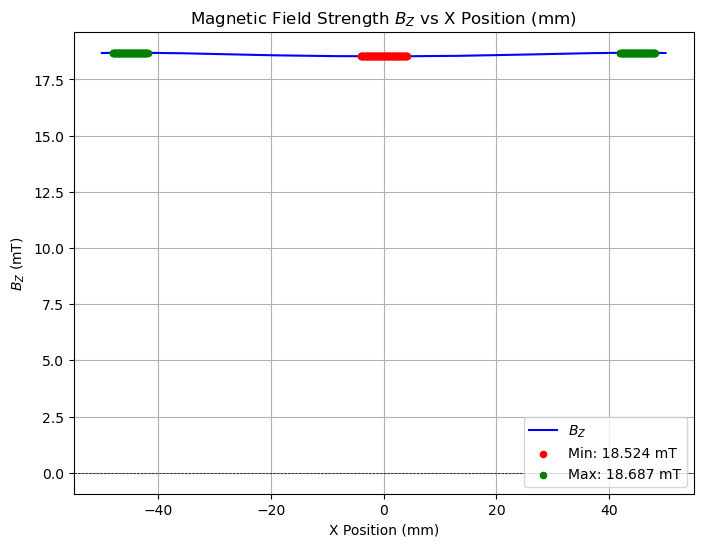

In [47]:
# Warm-up: call the adaptive function once to trigger JAX compilation.
_ = adaptive_run_field_calculation_jax()
# Run the adaptive field calculation using the tolerance defined.

start_time = time.time()
result, chosen_order = adaptive_run_field_calculation_jax()
obs = determine_observation_points(X_VAL, Y_VAL, Z_VAL)
end_time = time.time()
print("Time taken for adaptive_run_field_calculation_jax: {:.4f} seconds".format(end_time - start_time))
print("Chosen Legendre polynomial order:", chosen_order)

# If the observation coordinate is along x, plot the field versus x.
plot_Bz()

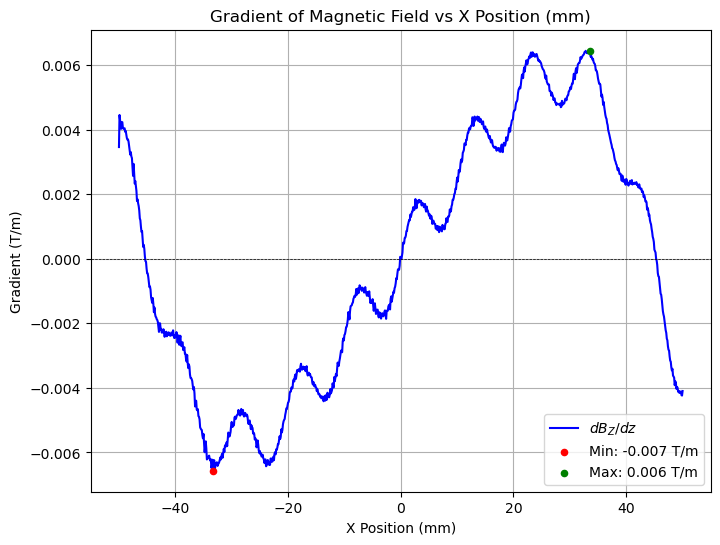

In [48]:
plot_derivative()

Time taken for adaptive_run_field_calculation_jax: 0.0010 seconds


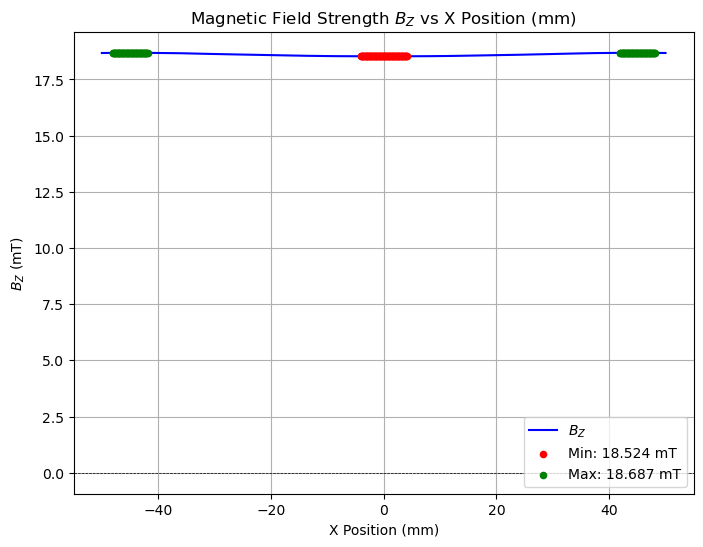

In [36]:
# Precompute Legendre nodes/weights only for the fixed order.
NODES_DICT, WEIGHTS_DICT = fixed_precompute_leggauss([FIXED_ORDER])
NODES = NODES_DICT[FIXED_ORDER]
WEIGHTS = WEIGHTS_DICT[FIXED_ORDER]

# Precompute integration parameters using the observation values and grid settings.
X_MINS, X_MAXS, Y_MINS, Y_MAXS, x_flat, y_flat, z_flat = fixed_setup_integration(X_VAL, Y_VAL, Z_VAL, A_TOTAL, A_ONE, B_TOTAL, B_ONE)

# Warm-up: call the adaptive function once to trigger JAX compilation.
_ = fixed_run_field_calculation_jax(x_flat, y_flat, z_flat, ZL, H, MZ)
# Run the adaptive field calculation using the tolerance defined.

start_time = time.time()
result = fixed_run_field_calculation_jax(x_flat, y_flat, z_flat, ZL, H, MZ)
obs = determine_observation_points(X_VAL, Y_VAL, Z_VAL)
end_time = time.time()
print("Time taken for adaptive_run_field_calculation_jax: {:.4f} seconds".format(end_time - start_time))
# print("Chosen Legendre polynomial order:", chosen_order)

# If the observation coordinate is along x, plot the field versus x.
plot_Bz(mode="Fixed")

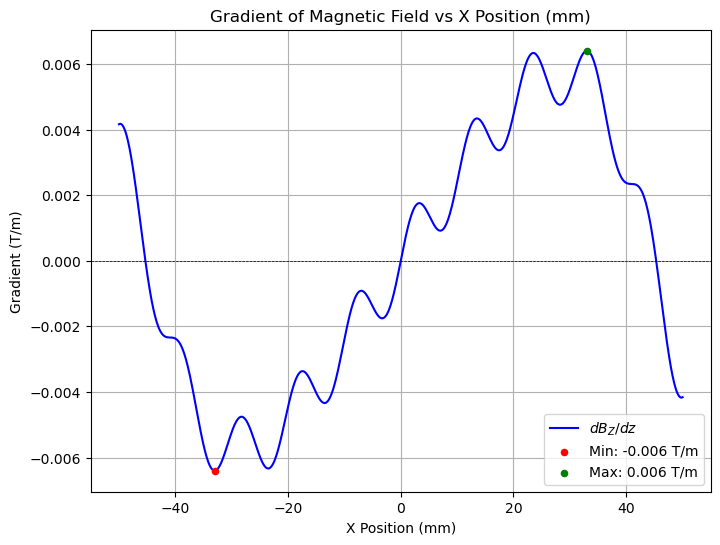

In [37]:
# # Get all gradients at once.
# grad_x, grad_y, grad_z = compute_derivative_fixed(40e-3, 10e-3, 0.0, ZL, H, MZ) # compute_derivative_fixed(40e-3, 10e-3, 0.0, ZL, H, MZ) = -1.79, -171, 
# # compute_derivative_fixed(X_VAL, Y_VAL, Z_VAL, ZL, H, MZ)

# print("Gradient with respect to x:", grad_x)
# print("Gradient with respect to y:", grad_y)

plot_derivative(mode = "Fixed")

## Optimization

Optimization will compare two techniques: a parameter sweep and JAX optimization. A parameter sweep goes over every single (reasonable) value for ZL and calculates the absolute difference between Bz and 20 mT at the observation points. This gives insight in the deviation from 20mT and gives the optimal configuration.

In [55]:
#------------------------------------------------------------------
# generate_zl_configurations: generates all ZL configurations.
# Values are discretized between a lower and upper bound with fixed steps. 
# The array is mirrored to create a symmetric configuration.
#------------------------------------------------------------------
def generate_zl_configurations(low, high, step):
    possible_values = np.arange(low, high + step/2, step)
    half = N_X // 2
    is_odd = N_X % 2 == 1

    # When N_X is odd, generate ⌊N_X/2⌋ + 1 independent values (including the center)
    num_independent = half + 1 if is_odd else half
    combinations = itertools.product(possible_values, repeat=num_independent)

    configs = []
    for combo in combinations:
        if is_odd:
            mirrored = list(combo[:half])[::-1]  # exclude center for mirroring
        else:
            mirrored = list(combo)[::-1]
        config = np.array(list(combo) + mirrored)
        configs.append(config)

    return np.array(configs)


# Example usage:
zl_configs = generate_zl_configurations(17e-3, 20e-3, 1e-3)
print("Number of configurations:", zl_configs.shape[0])
print("First configuration:", zl_configs[0])
print("Test configuration:", zl_configs[511])

Number of configurations: 262144
First configuration: [0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017
 0.017 0.017 0.017 0.017 0.017 0.017]
Test configuration: [0.017 0.017 0.017 0.017 0.018 0.02  0.02  0.02  0.02  0.02  0.02  0.02
 0.02  0.018 0.017 0.017 0.017 0.017]


In [60]:
#------------------------------------------------------------------
# total_error: Computes the total error between Bz at the observation points and a reference value.
#------------------------------------------------------------------
@jax.jit
def total_error(x_flat, y_flat, z_flat, zl, h, mz, B_REF):
    # Compute the z-component of the magnetic field at observation points.
    Bz = fixed_run_field_calculation_jax(x_flat, y_flat, z_flat, zl, h, mz)
    # Calculate the absolute error between Bz and the reference value.
    abs_error = jnp.abs(Bz - B_REF)**2
    # Sum the absolute errors over all observation points.
    return jnp.sum(abs_error)
B_REF = 0.0186 # Reference value for the magnetic field (in Tesla).
print("Total error:", total_error(x_flat, y_flat, z_flat, ZL, H, MZ, B_REF))

Total error: 0.0020060237


In [61]:
# Vectorize total_error over the ZL configurations.
# zl_configs is assumed to be an array of shape (num_configs, 18)
total_error_configs = jax.vmap(
    lambda zl: total_error(x_flat, y_flat, z_flat, zl, H, MZ, B_REF)
)

# Compute the error for every configuration.
all_errors = total_error_configs(zl_configs)

# Convert the result to a NumPy array (if needed).
all_errors_np = np.array(all_errors)

# Find the index of the configuration with the minimal error.
best_index = np.argmin(all_errors_np)
best_error = all_errors_np[best_index]
best_zl = zl_configs[best_index]

print("Best configuration error:", best_error)
print("Best configuration:", best_zl)

Best configuration error: 2.2120998e-06
Best configuration: [0.017 0.017 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02
 0.02  0.02  0.02  0.02  0.017 0.017]


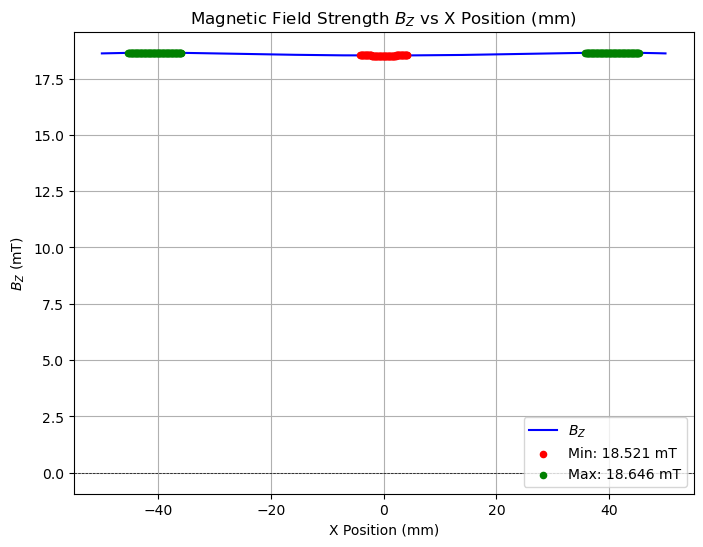

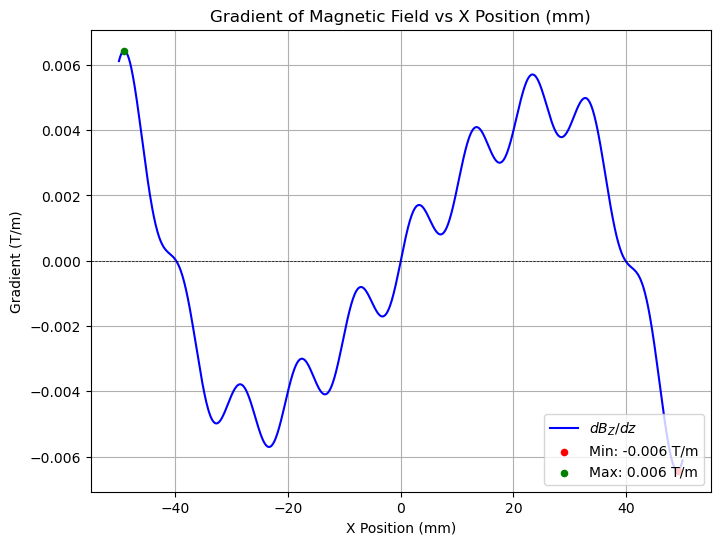

In [62]:
ZL = jnp.array(best_zl)  # Update ZL with the best configuration.
plot_Bz(mode="Fixed")
plot_derivative(mode="Fixed")

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np

# Lets begin
# Assume these globals (or parameters) are defined appropriately:
# X_VAL, Y_VAL, Z_VAL, H, MZ, A_TOTAL, A_ONE, B_TOTAL, B_ONE, x_flat

# fixed_run_field_calculation_jax is your function that computes the field:
@jax.jit
def fixed_run_field_calculation_jax(X_VAL, Y_VAL, Z_VAL, ZL, H, MZ, 
                                      A_TOTAL, A_ONE, B_TOTAL, B_ONE):
    result = compute_all_Bz_for_points_jax(x_flat, y_flat, z_flat, 
                                             X_MINS, X_MAXS, Y_MINS, Y_MAXS, 
                                             ZL, H, MZ, nodes, weights)
    return result

# Define a loss function that computes the mean squared error in the region x in [-20e-3, 20e-3]
def loss_fn(ZL):
    # Compute the field using the current guess for ZL.
    result = fixed_run_field_calculation_jax(X_VAL, Y_VAL, Z_VAL, ZL, H, MZ, 
                                               A_TOTAL, A_ONE, B_TOTAL, B_ONE)
    # Create a mask for observation points between x = -20e-3 and x = 20e-3.
    mask = (x_flat >= -45e-3) & (x_flat <= 45e-3)
    # Extract the corresponding field values.
    region_values = result[mask]
    # Compute the mean squared error against the target value 0.065.
    return jnp.mean((region_values - 0.02) ** 2)

# Initialize ZL as an array (your initial guess).
ZL = jnp.array([15e-3] * 22)  # 10-element array as in your example

# Set optimization parameters.
learning_rate = 0.001
num_iterations = 1000

# Optimization loop using gradient descent.
for i in range(num_iterations):
    # Compute the gradient of the loss with respect to ZL.
    grad_loss = jax.grad(loss_fn)(ZL)
    # Update ZL.
    ZL = ZL - learning_rate * grad_loss
    if i % 100 == 0:
        current_loss = loss_fn(ZL)
        print(f"Iteration {i}: Loss = {current_loss}")

optimized_ZL_np = np.array(ZL)
print("Optimized ZL:", ", ".join(map(str, optimized_ZL_np)))



Iteration 0: Loss = 9.303418124773088e-08
Iteration 100: Loss = 8.611065283048447e-08
Iteration 200: Loss = 7.970278659286123e-08
Iteration 300: Loss = 7.377314403811397e-08
Iteration 400: Loss = 6.829106524719464e-08
Iteration 500: Loss = 6.32217478369057e-08
Iteration 600: Loss = 5.8533760949330826e-08
Iteration 700: Loss = 5.419596504907531e-08
Iteration 800: Loss = 5.018263493639097e-08
Iteration 900: Loss = 4.646653906092979e-08
Optimized ZL: 0.015000931, 0.015001862, 0.015003657, 0.015007463, 0.015013085, 0.015007498, 0.01497554, 0.014944282, 0.014925801, 0.014915318, 0.014910416, 0.014910416, 0.014915318, 0.014925805, 0.014944279, 0.014975554, 0.015007523, 0.015013086, 0.015007461, 0.015003653, 0.015001862, 0.015000931
